In [29]:
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import gymnasium as gym
import matplotlib.pyplot as plt
import cv2

In [30]:
physical_devices = tf.config.list_physical_devices("GPU")
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Creacion del modelo


In [31]:
def build_model(state_dim, action_dim):
    model = Sequential(
        [
            Dense(64, input_dim=state_dim, activation="relu"),
            Dense(128, activation="relu"),
            Dense(action_dim, activation="linear"),
        ]
    )
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
    return model

## Clase DQNAgent con historial de pérdidas


In [32]:
class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        replay_size=10000,
        batch_size=64,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        discretization_bins=10,  # Nuevas variables para la discretización
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = deque(maxlen=replay_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.loss_history = []  # Para almacenar la pérdida promedio por episodio
        self.mae_history = []  # Para almacenar el MAE promedio por episodio
        self.discretization_bins = (
            discretization_bins  # Número de intervalos para discretizar cada dimensión
        )

        # Redes Q y Target
        self.q_network = build_model(state_dim, action_dim)
        self.target_network = build_model(state_dim, action_dim)
        self.update_target_network()

    def update_target_network(self):
        """Copiar los pesos de la red principal a la red target."""
        self.target_network.set_weights(self.q_network.get_weights())

    def select_action(self, state):
        """Selecciona una acción siguiendo la política \(\epsilon\)-greedy."""
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_dim - 1)  # Acción aleatoria
        state = np.expand_dims(state, axis=0)
        q_values = self.q_network.predict(state, verbose=0)
        return np.argmax(q_values[0])  # Acción con el mayor valor Q

    def store_experience(self, state, action, reward, next_state, terminated):
        """Almacena la experiencia en el buffer de repetición."""
        self.replay_buffer.append((state, action, reward, next_state, terminated))

    def train(self):
        """Entrena la red Q utilizando un batch de experiencias."""
        if len(self.replay_buffer) < self.batch_size:
            return

        # Muestra un batch aleatorio de experiencias
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, terminateds = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)

        # Calcular las predicciones de Q de la red y la red target
        q_values = self.q_network.predict(states, verbose=0)
        q_values_next = self.target_network.predict(next_states, verbose=0)

        # Actualizar Q(s, a) utilizando el valor máximo de la siguiente acción
        for i in range(self.batch_size):
            if terminateds[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                q_values[i, actions[i]] = rewards[i] + self.gamma * np.max(
                    q_values_next[i]
                )

        # Entrenamiento de la red
        history = self.q_network.fit(states, q_values, epochs=1, verbose=0)

        # Almacenar las métricas de pérdida y MAE
        self.loss_history.append(history.history["loss"][0])
        self.mae_history.append(history.history["mae"][0])

    def discretize_state(self, state):
        """Convierte el estado continuo en un estado discreto"""
        discretized_state = np.zeros(self.state_dim)
        for i in range(self.state_dim):
            discretized_state[i] = np.digitize(
                state[i], np.linspace(-1, 1, self.discretization_bins)
            )
        return tuple(discretized_state)

In [33]:
def plot_scores(scores):
    plt.figure(figsize=(10, 6))
    plt.plot(scores, label="Puntaje por episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Puntaje")
    plt.title("Evolución del Puntaje")
    plt.legend()
    plt.grid()
    plt.show()


def plot_loss(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, label="Pérdida por batch")
    plt.xlabel("Batch")
    plt.ylabel("Pérdida (Loss)")
    plt.title("Evolución de la Pérdida")
    plt.legend()
    plt.grid()
    plt.show()


def plot_mae(mae_history):
    plt.figure(figsize=(10, 6))
    plt.plot(mae_history, label="MAE por batch")
    plt.xlabel("Batch")
    plt.ylabel("Error Absoluto Medio (MAE)")
    plt.title("Evolución del MAE")
    plt.legend()
    plt.grid()
    plt.show()

## Entrenamiento del DQN con métricas y video


In [34]:
def train_dqn(
    env_name="LunarLander-v3",
    episodes=10,
    target_update=10,
    video_filename="dqn_training_video.mp4",
):
    env = gym.make(env_name, render_mode="rgb_array")
    state_dim = env.observation_space.shape[0]  # LunarLander tiene 8 estados
    action_dim = env.action_space.n  # LunarLander tiene 4 acciones (discreto)

    agent = DQNAgent(state_dim, action_dim)
    scores = []

    # Configuración de video
    env.reset()
    sample_frame = env.render()[0]
    height, width, channels = (
        sample_frame.shape
        if len(sample_frame.shape) == 3
        else (sample_frame.shape[0], sample_frame.shape[1], 1)
    )

    obj_video = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(
        video_filename, obj_video, 30, (width, height), isColor=(channels == 3)
    )

    for episode in range(episodes):
        state = env.reset()[0]
        state = np.array(state, dtype=np.float32)
        episode_score = 0

        while True:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            episode_score += reward

            # Ajuste de recompensa para acelerar el aprendizaje
            if terminated:
                if reward > 200:
                    reward += 100  # Recompensa adicional por aterrizajes exitosos
                elif reward < -200:
                    reward -= 100  # Penalización por choque

            agent.store_experience(state, action, reward, next_state, terminated)
            agent.train()

            state = next_state

            frame = env.render()[0]
            frame_bgr = (
                cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                if len(frame.shape) == 3
                else cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            )
            out.write(frame_bgr)

            if terminated:
                break

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        scores.append(episode_score)

        if episode % target_update == 0:
            agent.update_target_network()

        print(
            f"Episode {episode}, Score: {episode_score:.2f}, Epsilon: {agent.epsilon:.2f}"
        )

    out.release()
    env.close()

    plot_scores(scores)
    plot_loss(agent.loss_history)
    plot_mae(agent.mae_history)

    return scores, agent.loss_history, agent.mae_history


## Entrenar y graficar resultados


Episode 0, Score: -265.11, Epsilon: 0.99
Episode 1, Score: -142.66, Epsilon: 0.99
Episode 2, Score: -111.14, Epsilon: 0.99
Episode 3, Score: -342.90, Epsilon: 0.98
Episode 4, Score: -142.78, Epsilon: 0.98
Episode 5, Score: -140.55, Epsilon: 0.97
Episode 6, Score: -214.67, Epsilon: 0.97
Episode 7, Score: -114.22, Epsilon: 0.96
Episode 8, Score: -213.22, Epsilon: 0.96
Episode 9, Score: -212.46, Epsilon: 0.95
Episode 10, Score: -272.18, Epsilon: 0.95
Episode 11, Score: -417.45, Epsilon: 0.94
Episode 12, Score: -89.34, Epsilon: 0.94
Episode 13, Score: -203.44, Epsilon: 0.93
Episode 14, Score: -296.48, Epsilon: 0.93
Episode 15, Score: -168.21, Epsilon: 0.92
Episode 16, Score: -340.96, Epsilon: 0.92
Episode 17, Score: -183.07, Epsilon: 0.91
Episode 18, Score: -353.67, Epsilon: 0.91
Episode 19, Score: -165.35, Epsilon: 0.90
Episode 20, Score: -284.13, Epsilon: 0.90
Episode 21, Score: -62.29, Epsilon: 0.90
Episode 22, Score: -118.97, Epsilon: 0.89
Episode 23, Score: -120.09, Epsilon: 0.89
Epis

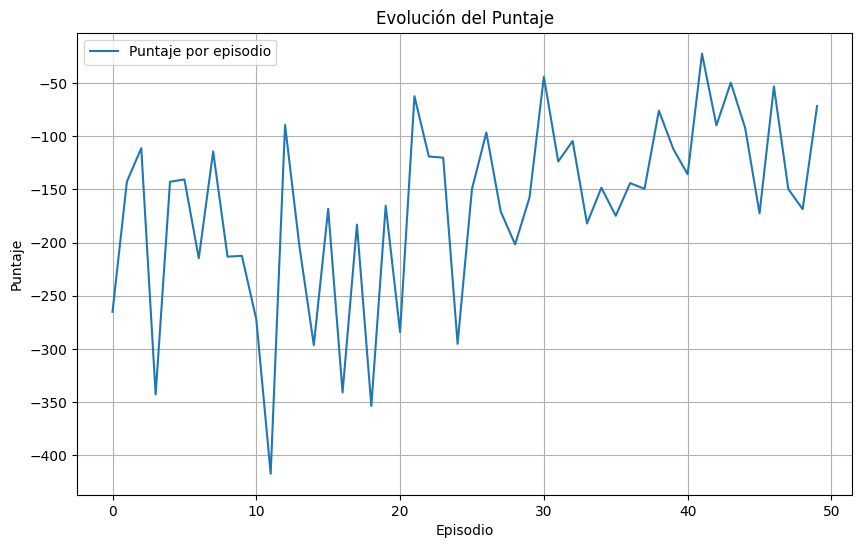

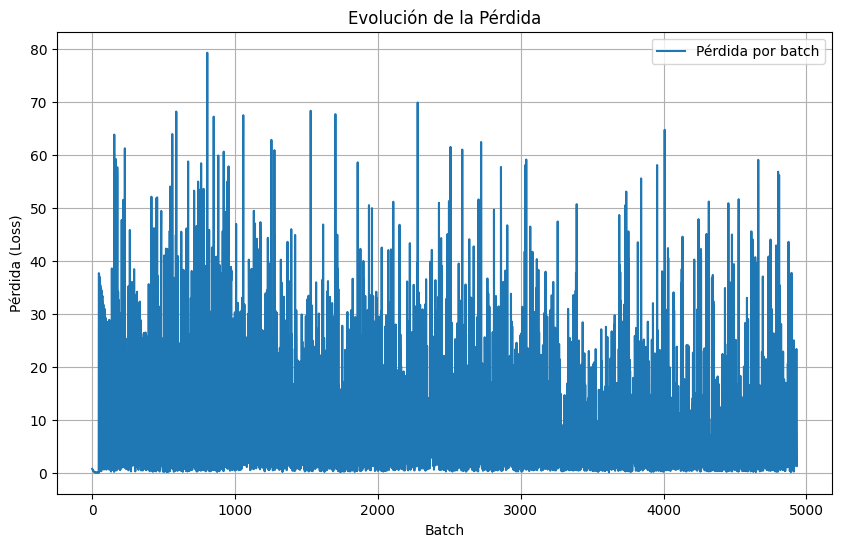

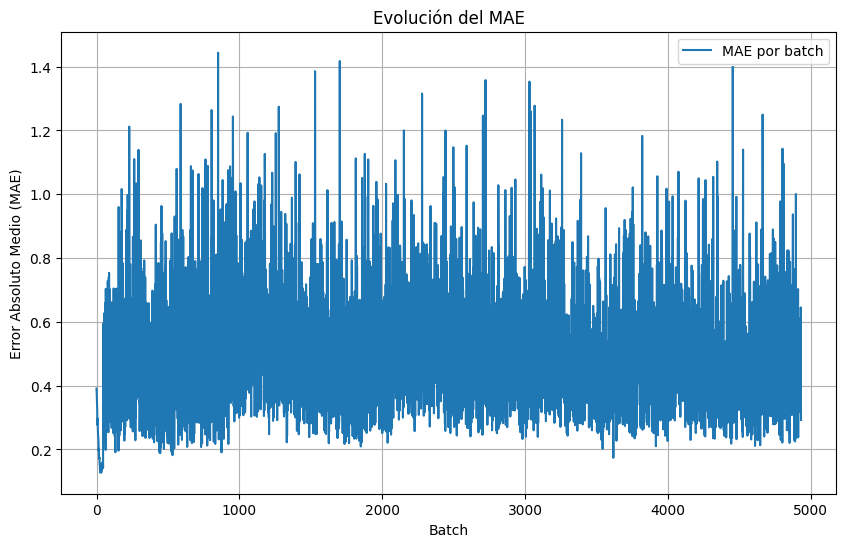

In [35]:
scores, loss_history, mae_history = train_dqn(episodes=50)
